In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Relative paths
coconut_file = "../results/results_all_big_networks_CoCoNUT.xlsx"
# coarsenet_file = "../results/bignets_1755552369/bignets_coarsenet_results.xlsx"
coarsenet_file = "../results/coarsenet_big_nets_1756150920/coarsenet_big_nets_results.xlsx"

In [24]:
# Load CoCoNUT results
coco_xls = pd.ExcelFile(coconut_file)
coconut_parts = []
if "Simples" in coco_xls.sheet_names:
    coconut_parts.append(pd.read_excel(coconut_file, sheet_name="Simples"))
if "Complex" in coco_xls.sheet_names:
    coconut_parts.append(pd.read_excel(coconut_file, sheet_name="Complex"))
coconut_df = pd.concat(coconut_parts, ignore_index=True)

In [25]:
# Load CoarseNet Files
cn_xls = pd.ExcelFile(coarsenet_file)
coarsenet_df = pd.read_excel(coarsenet_file, sheet_name=cn_xls.sheet_names[0])

In [26]:
# Normalize
for df in (coconut_df, coarsenet_df):
    df["Alpha"] = pd.to_numeric(df["Alpha"], errors="coerce")
    df["Reduced"] = pd.to_numeric(df["Reduced"], errors="coerce")
    for col in ("Network", "Metric"):
        df[col] = df[col].astype(str).str.strip()

In [27]:
def get_common_graphs(coconut_df, coarsenet_df):
    coco_graphs = set(coconut_df["Network"].unique())
    coarse_graphs = set(coarsenet_df["Network"].unique())
    return coco_graphs.intersection(coarse_graphs)

def metrics_for_graph(graph, coconut_df, coarsenet_df):
    m1 = set(coconut_df.loc[coconut_df["Network"] == graph, "Metric"].unique())
    m2 = set(coarsenet_df.loc[coarsenet_df["Network"] == graph, "Metric"].unique())
    return m1.intersection(m2)

def rvi_softmax(df, graph, metric, method=None,
                alpha_col="Alpha", original_col="Original", reduced_col="Reduced",
                tau=1.0):
    """
    RVI_soft(tau) = ( sum_i exp(-alpha_i/tau) * |r_i - O| ) / ( |O| * sum_i exp(-alpha_i/tau) )
    """
    d = df[(df["Network"] == graph) & (df["Metric"] == metric)].copy()
    if method is not None:
        d = d[d["Method"] == method]
    d = d[[alpha_col, original_col, reduced_col]].dropna()
    if d.empty:
        return np.nan

    d = d.sort_values(alpha_col)
    O = float(d[original_col].iloc[0])
    alphas = d[alpha_col].values.astype(float)
    reduced = d[reduced_col].values.astype(float)

    w = np.exp(-alphas / float(tau))
    num = np.sum(w * np.abs(reduced - O))
    den = abs(O) * np.sum(w)
    return num / den if den > 0 else np.nan

def plot_graph_metrics(graph, coconut_df, coarsenet_df, tau=1.0):
    """
    Para cada métrica común del grafo:
      - Plotea CoCoNUT y CoarseNet vs Alpha
      - Dibuja línea horizontal con el 'Original' de CoCoNUT únicamente
      - Imprime RVI_soft de ambos métodos
    """
    # métricas comunes
    metrics_coco = set(coconut_df.loc[coconut_df["Network"] == graph, "Metric"].unique())
    metrics_cn = set(coarsenet_df.loc[coarsenet_df["Network"] == graph, "Metric"].unique())
    metrics = sorted(metrics_coco & metrics_cn)
    if not metrics:
        print(f"No hay métricas comunes para {graph}")
        return

    for metric in metrics:
        coco = coconut_df[(coconut_df["Network"] == graph) & (coconut_df["Metric"] == metric)].copy()
        coarse = coarsenet_df[(coarsenet_df["Network"] == graph) & (coarsenet_df["Metric"] == metric)].copy()
        if coco.empty or coarse.empty:
            continue

        coco = coco.sort_values("Alpha")
        coarse = coarse.sort_values("Alpha")

        # RVI para ambos métodos
        rvi_coco = rvi_softmax(coconut_df, graph, metric, method="CoCoNUT-ANY", tau=tau)
        rvi_cn   = rvi_softmax(coarsenet_df, graph, metric, method="CoarseNet", tau=tau)

        print(f"{graph} - {metric}  tau={tau}")
        print(f"  RVI_soft CoCoNUT  : {rvi_coco:.6f}")
        print(f"  RVI_soft CoarseNet: {rvi_cn:.6f}")

        # valor original solo de CoCoNUT
        O_coco = float(coco["Original"].iloc[0])

        # plot
        plt.figure(figsize=(6, 4))
        plt.plot(coco["Alpha"], coco["Reduced"], marker="o", label="CoCoNUT")
        plt.plot(coarse["Alpha"], coarse["Reduced"], marker="s", label="CoarseNet")
        plt.axhline(O_coco, linestyle="--", linewidth=1, label="Original")
        plt.title(f"{graph} - {metric}")
        plt.xlabel("Alpha")
        plt.ylabel("Reduced value")
        plt.legend()
        plt.grid(True)
        plt.show()

In [28]:
common_graphs = get_common_graphs(coconut_df, coarsenet_df)
print("Número de grafos comunes:", len(common_graphs))
print("Grafos comunes:", sorted(common_graphs))

Número de grafos comunes: 15
Grafos comunes: ['CorporatePeople-mainA', 'DrugsA', 'Internet-1997-A', 'Internet-1998-A', 'Malaria-PIN-mainA', 'ODLIS-mainA', 'PIN-Human-mainA', 'PINEcoli-validated-mainA', 'Software-Mysql-main-sA', 'Software-XMMS-main-sA', 'Trans-Ecoli-mainA', 'Transc-yeast-mainA', 'USAir97A', 'YeastS-main', 'geom-main']


CorporatePeople-mainA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.020975
  RVI_soft CoarseNet: nan


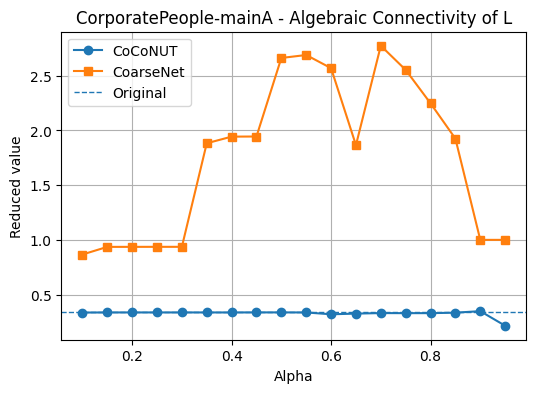

CorporatePeople-mainA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.548486
  RVI_soft CoarseNet: nan


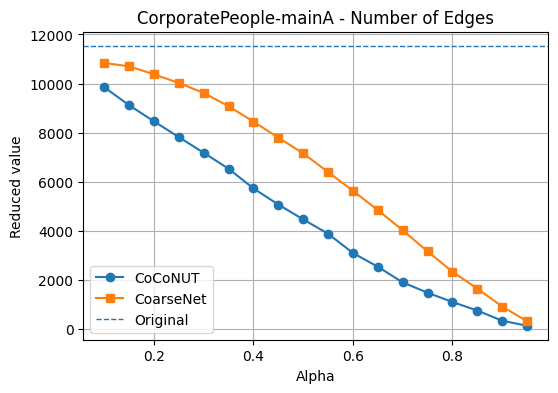

CorporatePeople-mainA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458610
  RVI_soft CoarseNet: nan


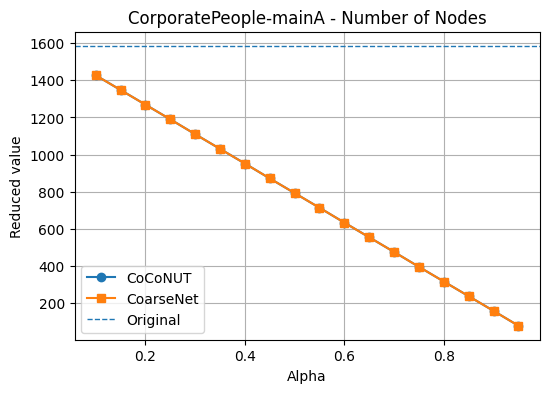

CorporatePeople-mainA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 1.722713
  RVI_soft CoarseNet: nan


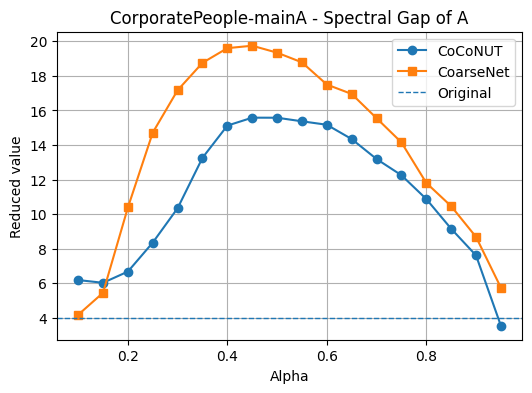

CorporatePeople-mainA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.154804
  RVI_soft CoarseNet: nan


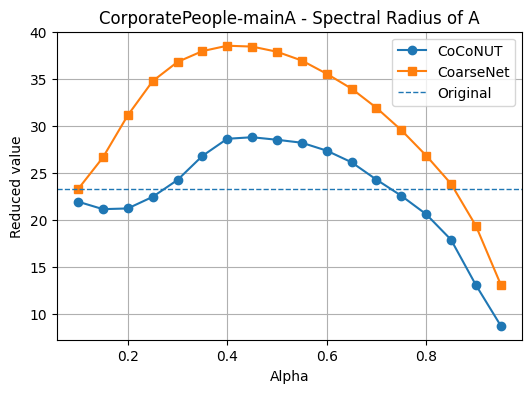

CorporatePeople-mainA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 3.126563
  RVI_soft CoarseNet: nan


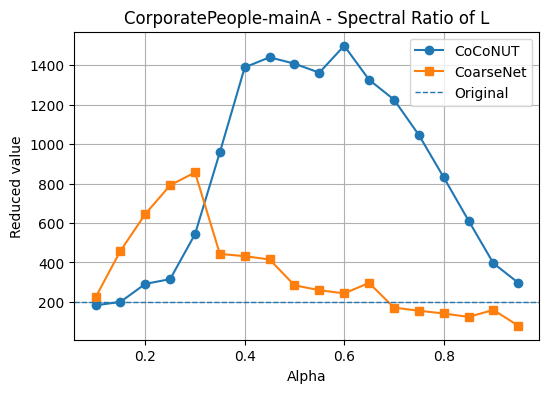

In [29]:
# Metric comparison for 'CorporatePeople-mainA'
plot_graph_metrics("CorporatePeople-mainA", coconut_df, coarsenet_df)

DrugsA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.878741
  RVI_soft CoarseNet: nan


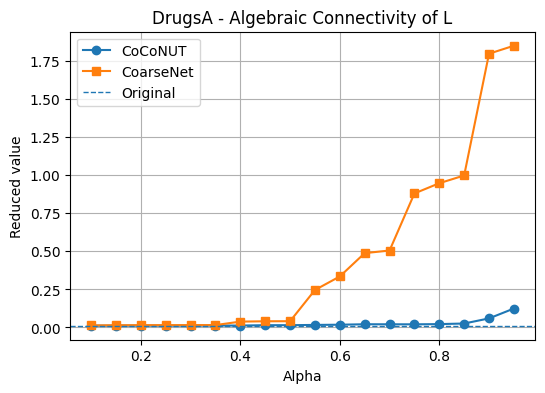

DrugsA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.637648
  RVI_soft CoarseNet: nan


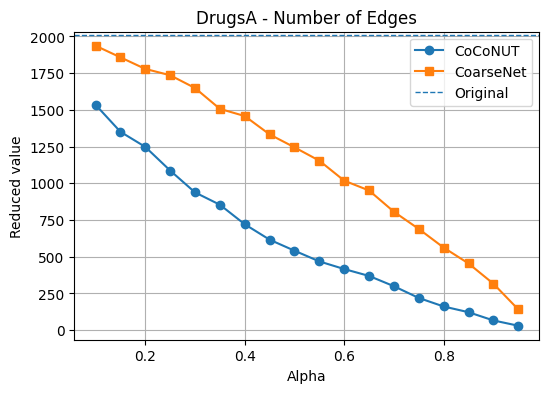

DrugsA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458593
  RVI_soft CoarseNet: nan


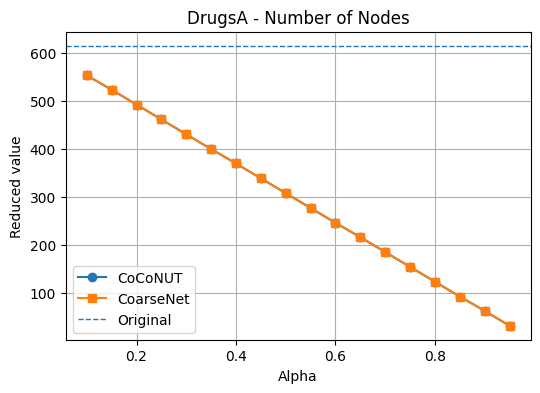

DrugsA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.677797
  RVI_soft CoarseNet: nan


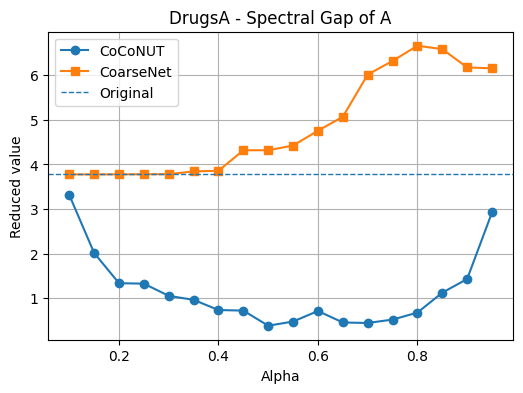

DrugsA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.469893
  RVI_soft CoarseNet: nan


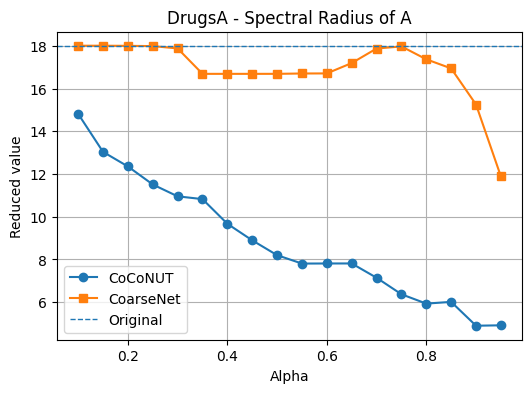

DrugsA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.432148
  RVI_soft CoarseNet: nan


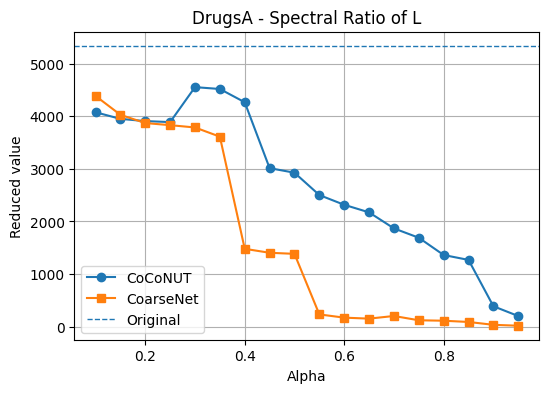

In [30]:
# Metric comparison for 'DrugsA'
plot_graph_metrics("DrugsA", coconut_df, coarsenet_df)

Internet-1997-A - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.422206
  RVI_soft CoarseNet: nan


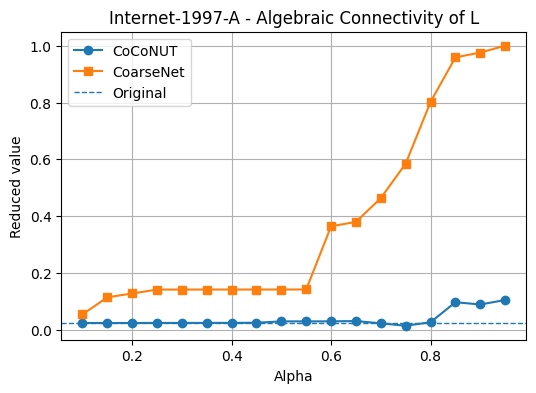

Internet-1997-A - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.463584
  RVI_soft CoarseNet: nan


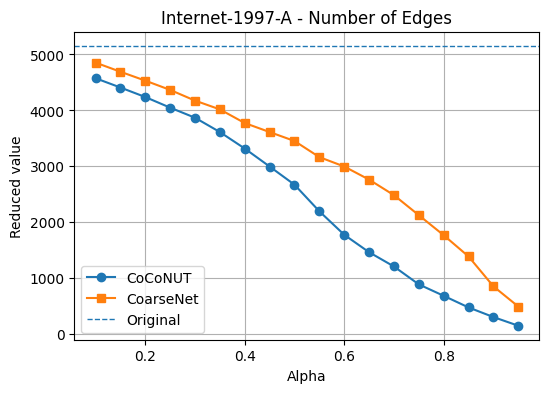

Internet-1997-A - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458608
  RVI_soft CoarseNet: nan


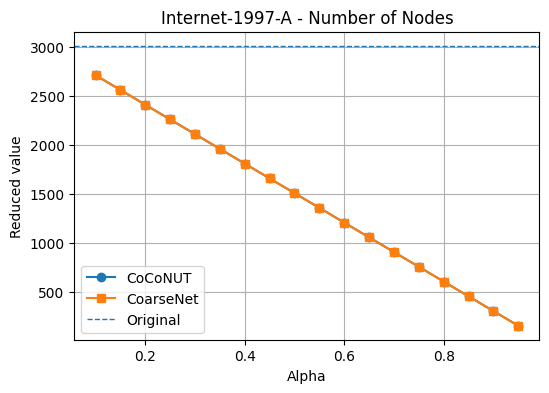

Internet-1997-A - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.200952
  RVI_soft CoarseNet: nan


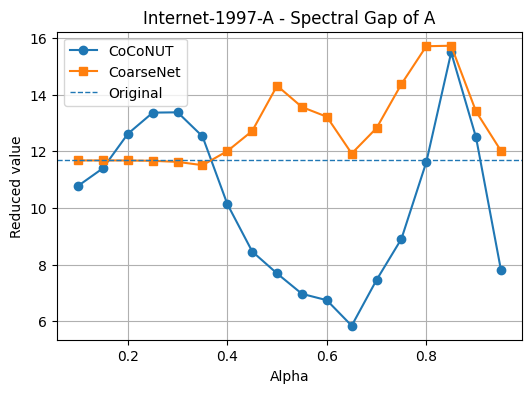

Internet-1997-A - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.290033
  RVI_soft CoarseNet: nan


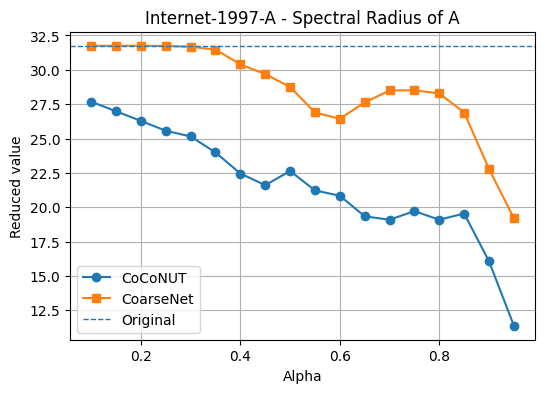

Internet-1997-A - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.606274
  RVI_soft CoarseNet: nan


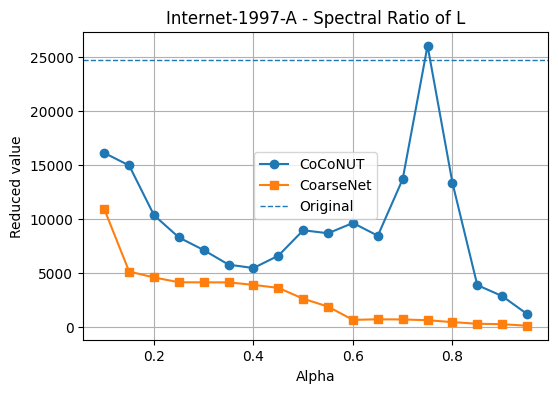

In [31]:
# Metric comparison for 'Internet-1997-A'
plot_graph_metrics("Internet-1997-A", coconut_df, coarsenet_df)

Internet-1998-A - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.109561
  RVI_soft CoarseNet: nan


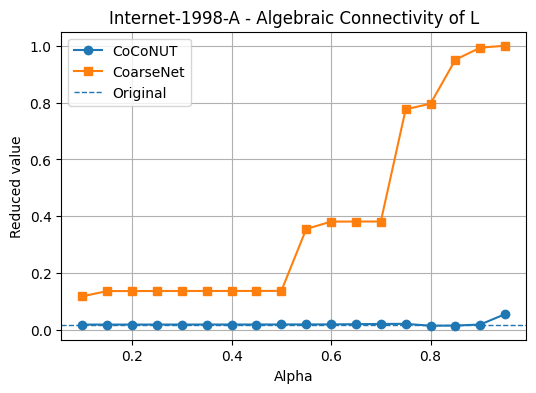

Internet-1998-A - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.452745
  RVI_soft CoarseNet: nan


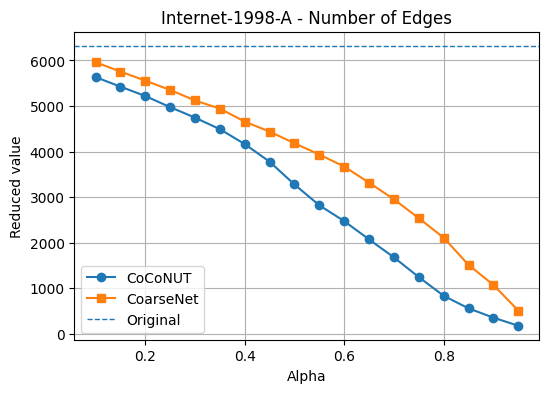

Internet-1998-A - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458594
  RVI_soft CoarseNet: nan


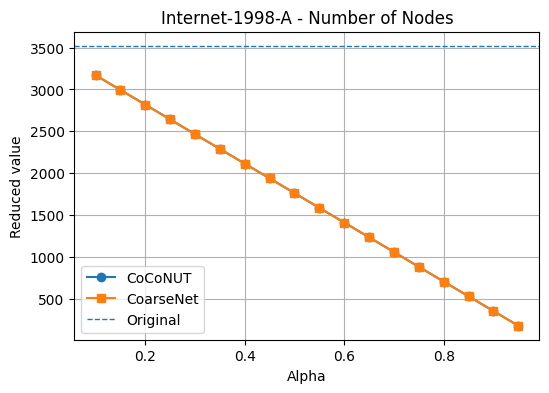

Internet-1998-A - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.185922
  RVI_soft CoarseNet: nan


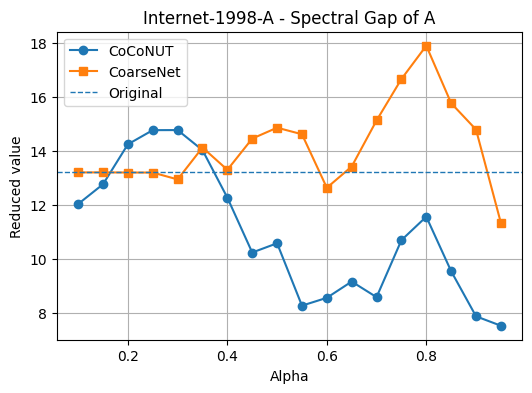

Internet-1998-A - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.302487
  RVI_soft CoarseNet: nan


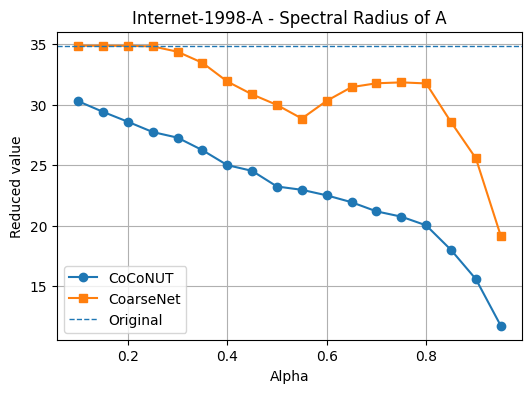

Internet-1998-A - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.626186
  RVI_soft CoarseNet: nan


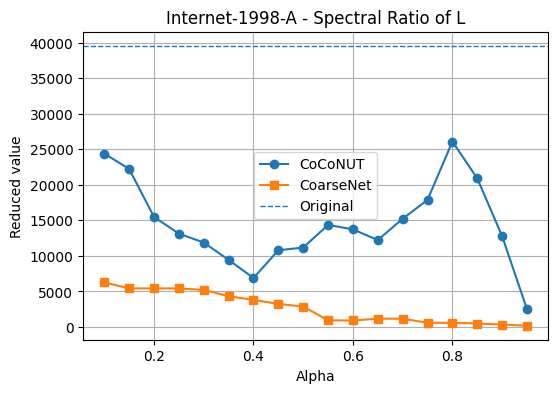

In [32]:
# Metric comparison for 'Internet-1998-A'
plot_graph_metrics("Internet-1998-A", coconut_df, coarsenet_df)

Malaria-PIN-mainA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.127478
  RVI_soft CoarseNet: nan


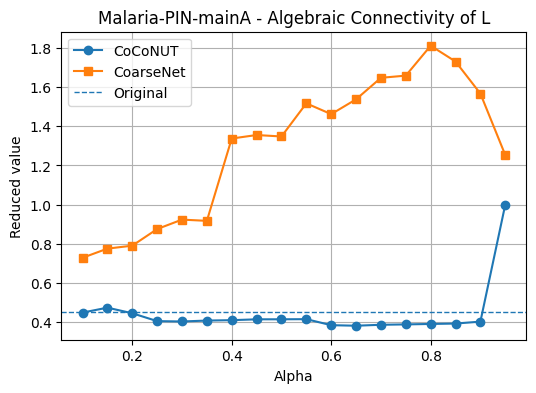

Malaria-PIN-mainA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.562564
  RVI_soft CoarseNet: nan


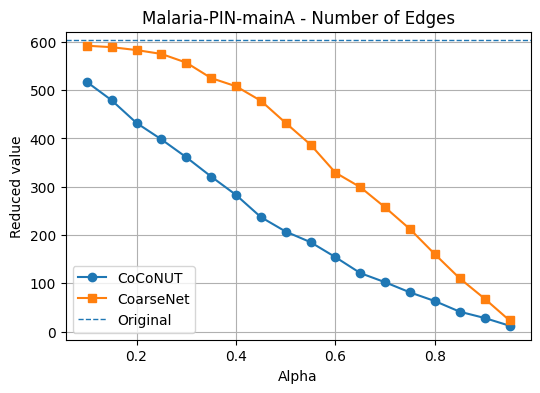

Malaria-PIN-mainA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458546
  RVI_soft CoarseNet: nan


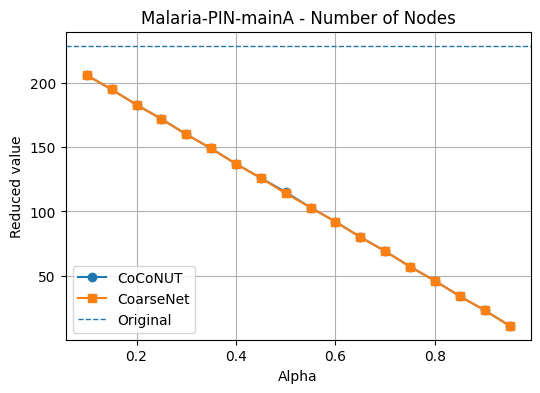

Malaria-PIN-mainA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 1.640199
  RVI_soft CoarseNet: nan


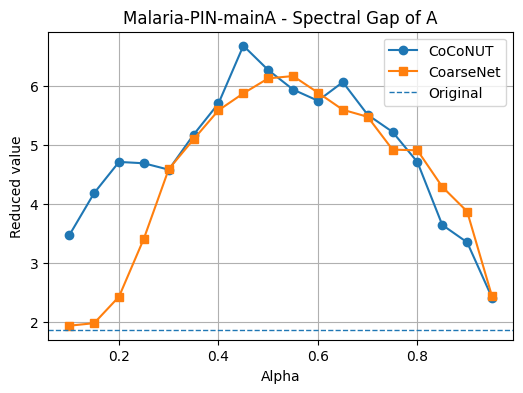

Malaria-PIN-mainA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.152970
  RVI_soft CoarseNet: nan


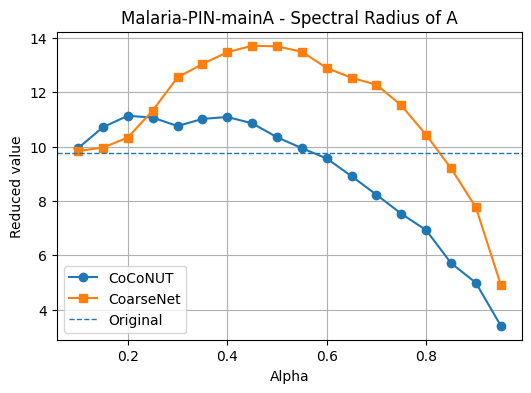

Malaria-PIN-mainA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 1.116330
  RVI_soft CoarseNet: nan


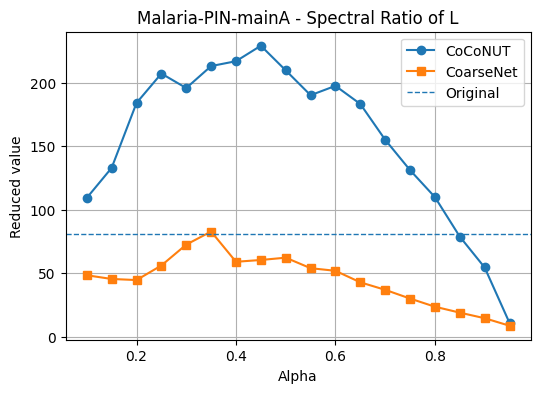

In [33]:
# Metric comparison for 'Malaria-PIN-mainA'
plot_graph_metrics("Malaria-PIN-mainA", coconut_df, coarsenet_df)

ODLIS-mainA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.752235
  RVI_soft CoarseNet: nan


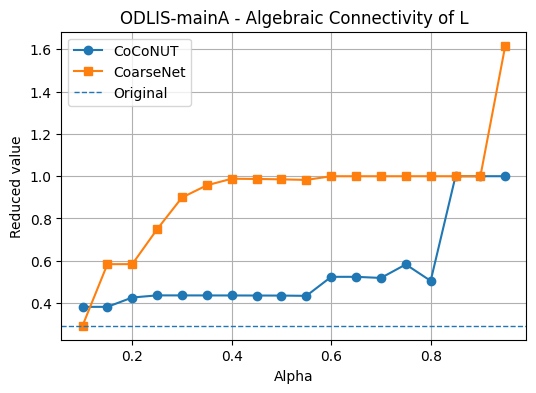

ODLIS-mainA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.554534
  RVI_soft CoarseNet: nan


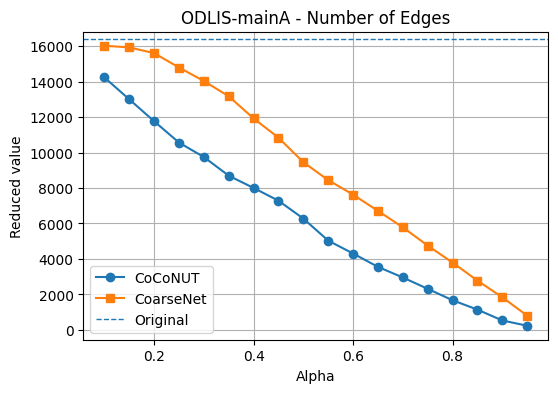

ODLIS-mainA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458602
  RVI_soft CoarseNet: nan


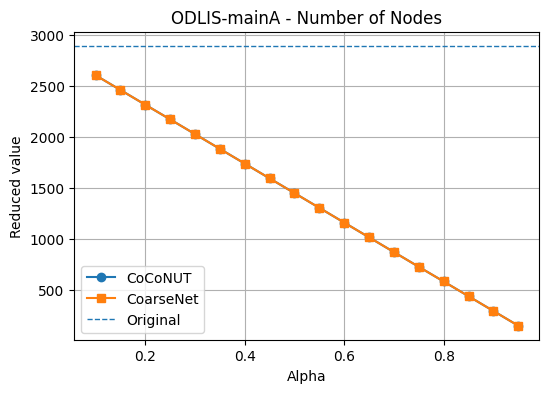

ODLIS-mainA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.263583
  RVI_soft CoarseNet: nan


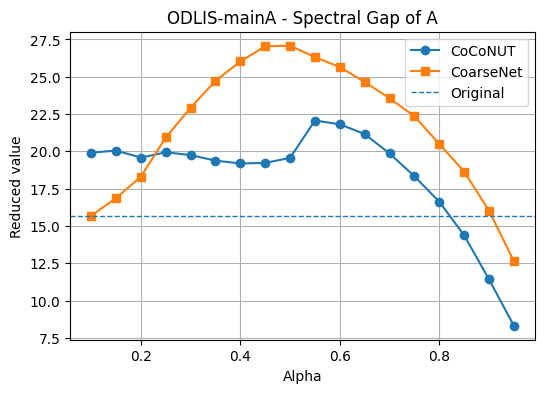

ODLIS-mainA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.158471
  RVI_soft CoarseNet: nan


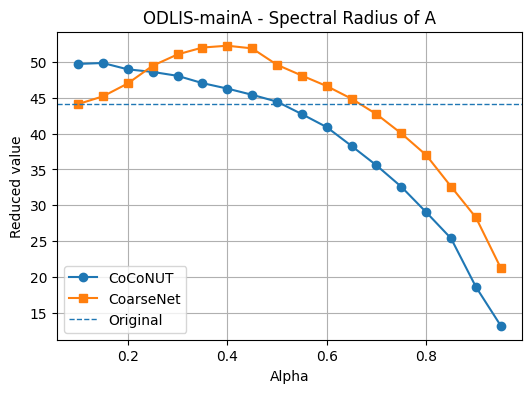

ODLIS-mainA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.470508
  RVI_soft CoarseNet: nan


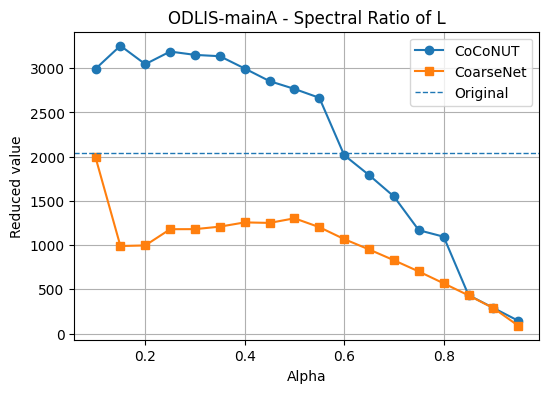

In [34]:
# Metric comparison for 'ODLIS-mainA'
plot_graph_metrics("ODLIS-mainA", coconut_df, coarsenet_df)

PINEcoli-validated-mainA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.642290
  RVI_soft CoarseNet: nan


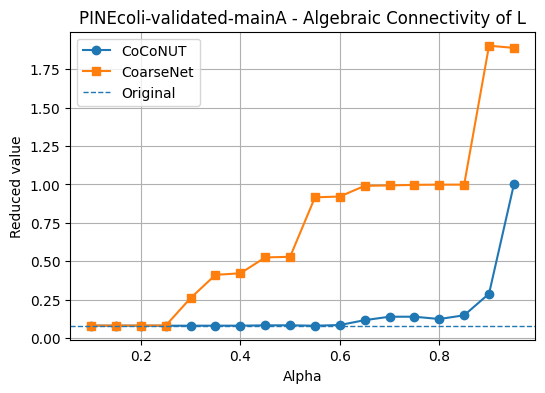

PINEcoli-validated-mainA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.708276
  RVI_soft CoarseNet: nan


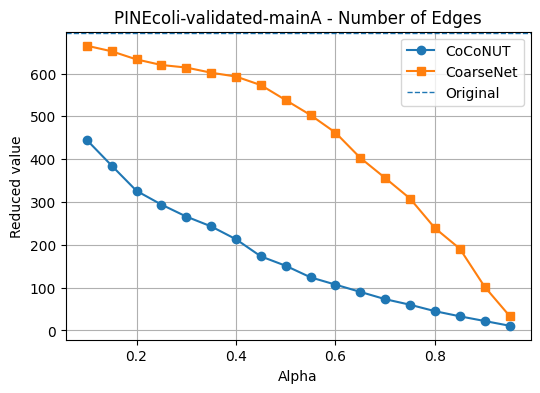

PINEcoli-validated-mainA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458705
  RVI_soft CoarseNet: nan


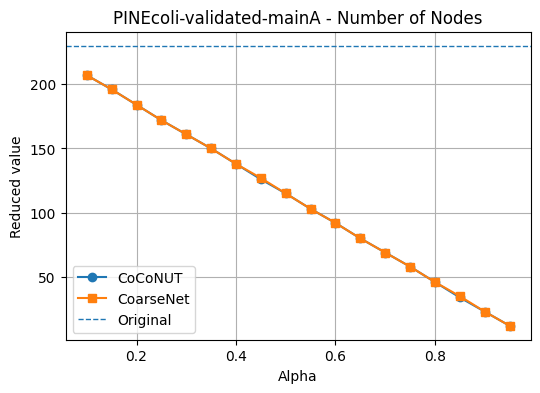

PINEcoli-validated-mainA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.590975
  RVI_soft CoarseNet: nan


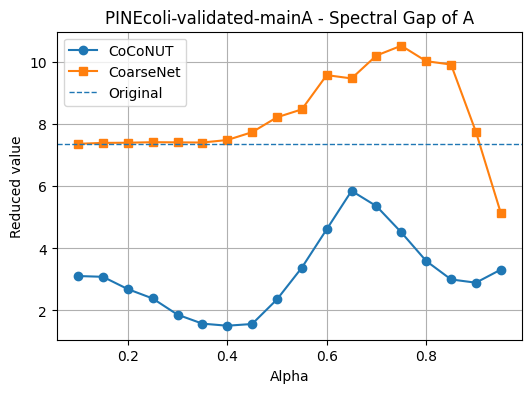

PINEcoli-validated-mainA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.504023
  RVI_soft CoarseNet: nan


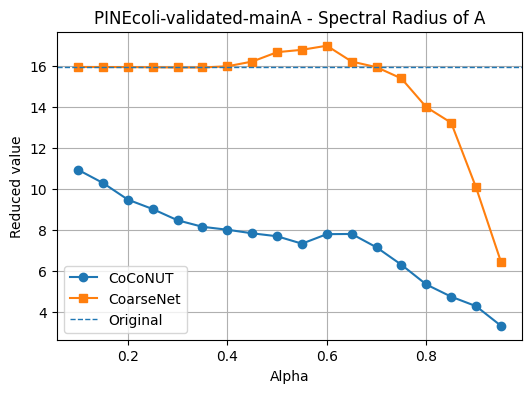

PINEcoli-validated-mainA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.316355
  RVI_soft CoarseNet: nan


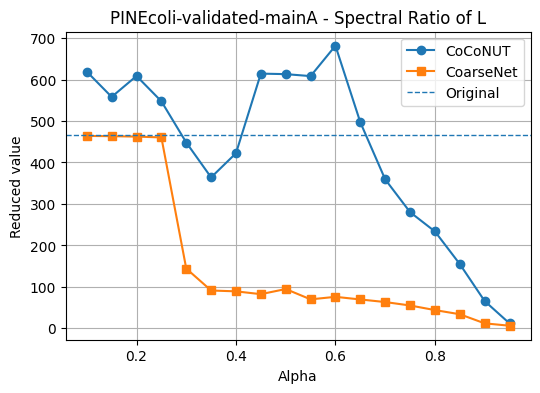

In [35]:
# Metric comparison for 'PINEcoli-validated-mainA'
plot_graph_metrics("PINEcoli-validated-mainA", coconut_df, coarsenet_df)

Software-Mysql-main-sA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 3.968002
  RVI_soft CoarseNet: nan


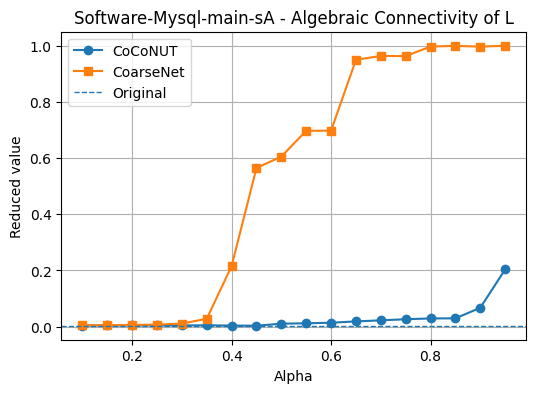

Software-Mysql-main-sA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.573367
  RVI_soft CoarseNet: nan


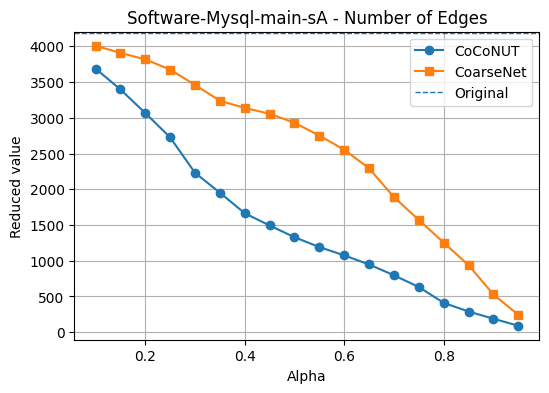

Software-Mysql-main-sA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458602
  RVI_soft CoarseNet: nan


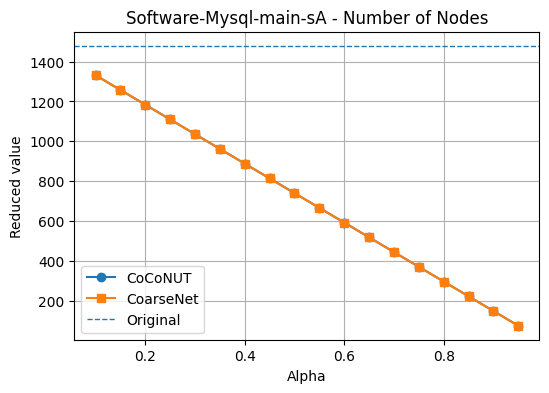

Software-Mysql-main-sA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.336790
  RVI_soft CoarseNet: nan


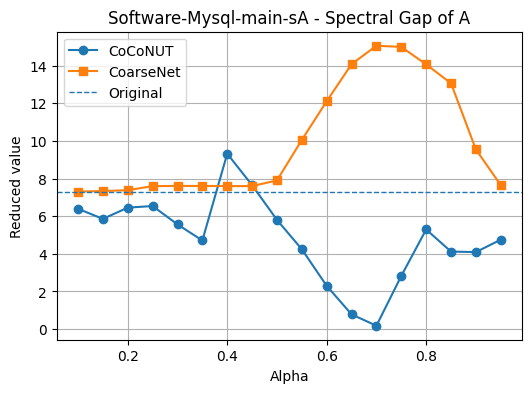

Software-Mysql-main-sA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.288900
  RVI_soft CoarseNet: nan


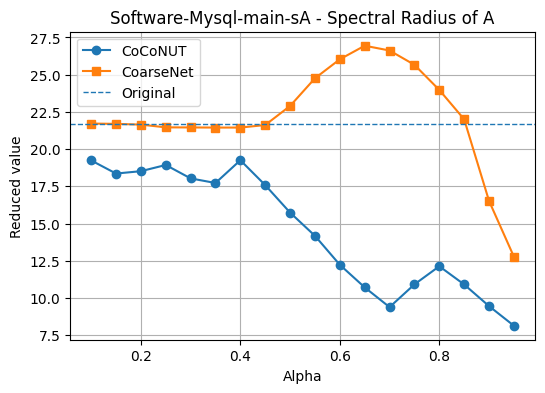

Software-Mysql-main-sA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.592510
  RVI_soft CoarseNet: nan


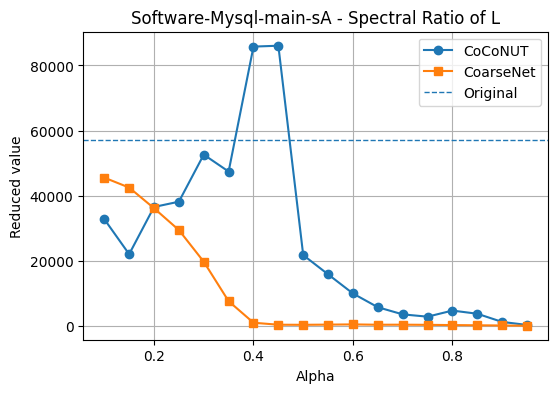

In [36]:
# Metric comparison for 'Software-Mysql-main-sA'
plot_graph_metrics("Software-Mysql-main-sA", coconut_df, coarsenet_df)

Software-XMMS-main-sA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 1.546847
  RVI_soft CoarseNet: nan


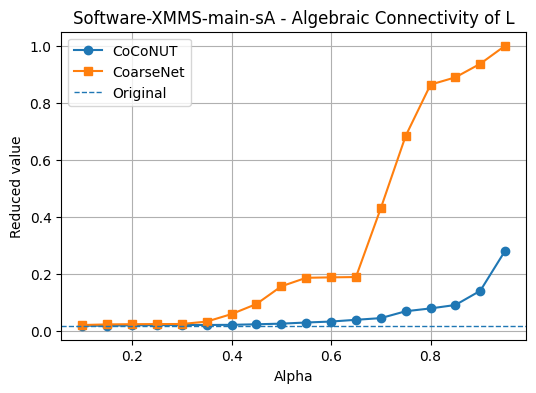

Software-XMMS-main-sA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.581126
  RVI_soft CoarseNet: nan


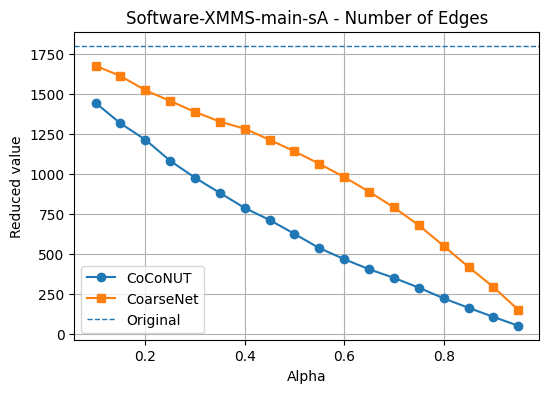

Software-XMMS-main-sA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458616
  RVI_soft CoarseNet: nan


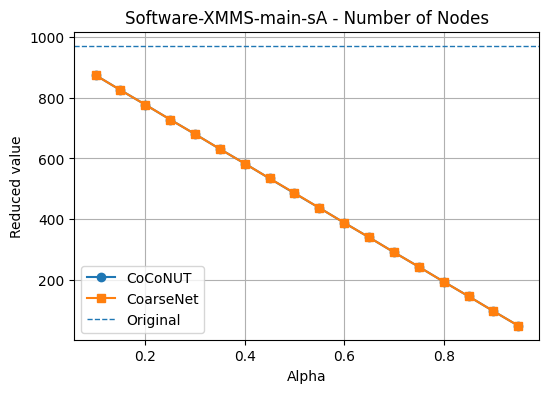

Software-XMMS-main-sA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 3.380672
  RVI_soft CoarseNet: nan


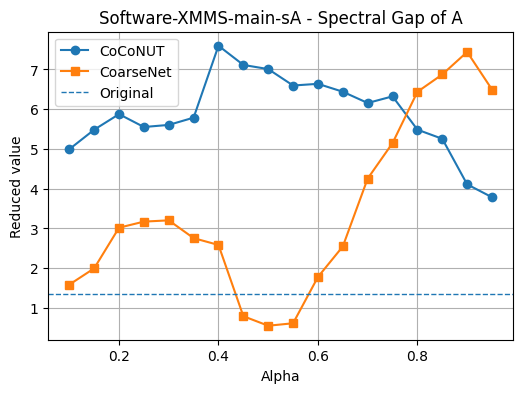

Software-XMMS-main-sA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.191597
  RVI_soft CoarseNet: nan


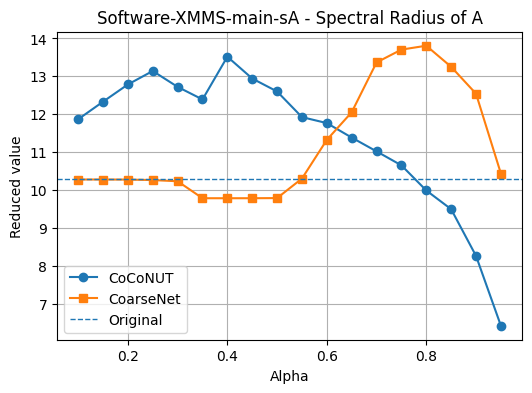

Software-XMMS-main-sA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 1.598278
  RVI_soft CoarseNet: nan


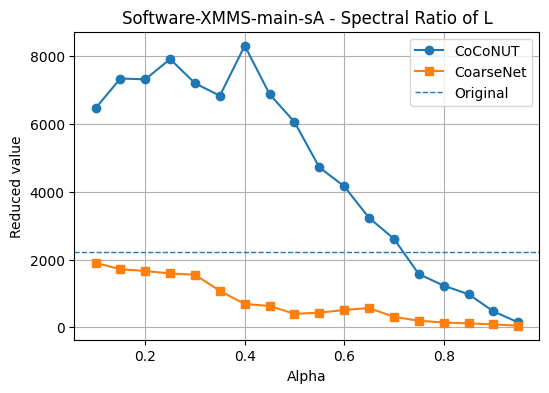

In [37]:
# Metric comparison for 'Software-XMMS-main-sA'
plot_graph_metrics("Software-XMMS-main-sA", coconut_df, coarsenet_df)

Trans-Ecoli-mainA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 1.722094
  RVI_soft CoarseNet: nan


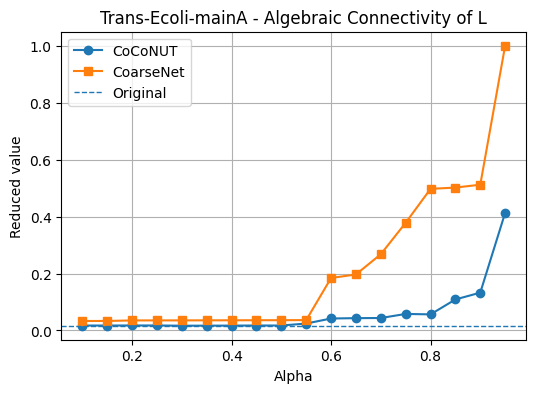

Trans-Ecoli-mainA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.520476
  RVI_soft CoarseNet: nan


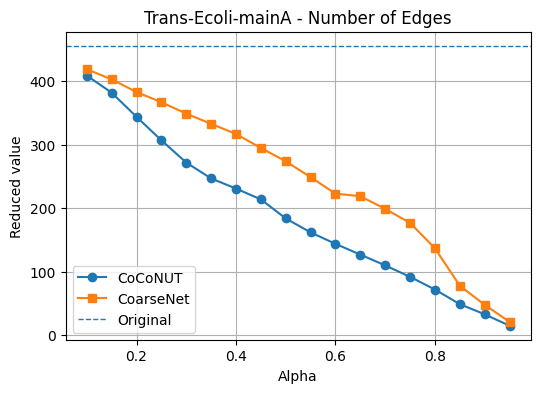

Trans-Ecoli-mainA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458673
  RVI_soft CoarseNet: nan


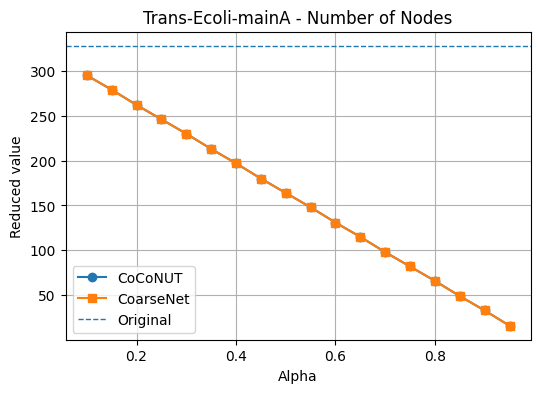

Trans-Ecoli-mainA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.396957
  RVI_soft CoarseNet: nan


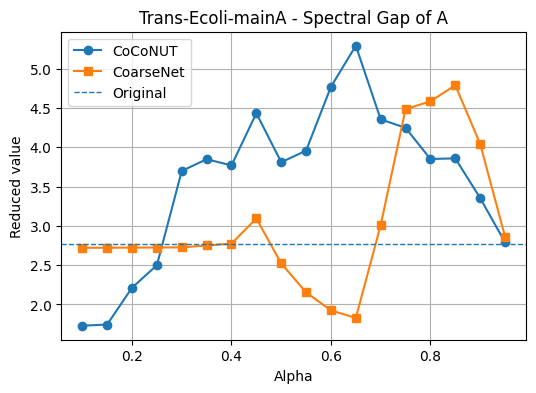

Trans-Ecoli-mainA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.169345
  RVI_soft CoarseNet: nan


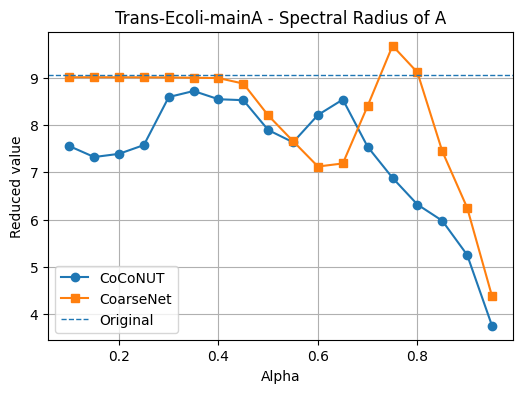

Trans-Ecoli-mainA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.467158
  RVI_soft CoarseNet: nan


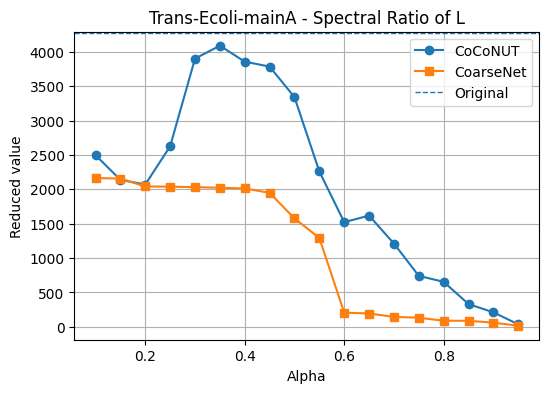

In [38]:
# Metric comparison for 'Trans-Ecoli-mainA'
plot_graph_metrics("Trans-Ecoli-mainA", coconut_df, coarsenet_df)

Transc-yeast-mainA - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.845532
  RVI_soft CoarseNet: nan


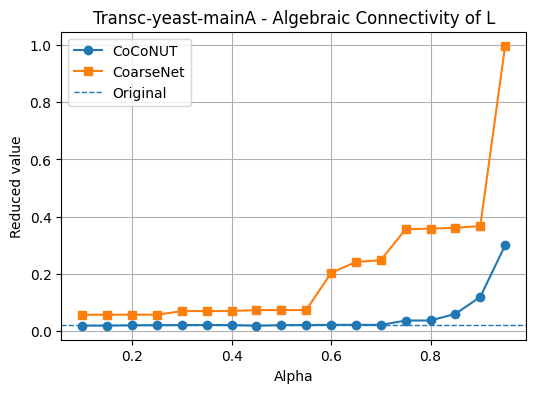

Transc-yeast-mainA - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.496776
  RVI_soft CoarseNet: nan


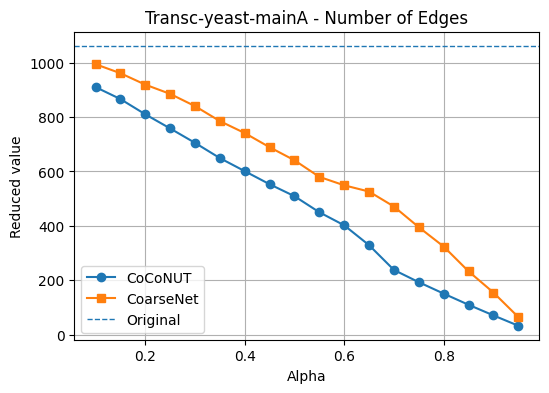

Transc-yeast-mainA - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458602
  RVI_soft CoarseNet: nan


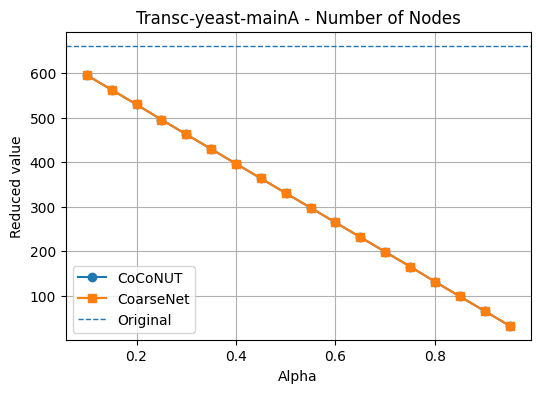

Transc-yeast-mainA - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.922636
  RVI_soft CoarseNet: nan


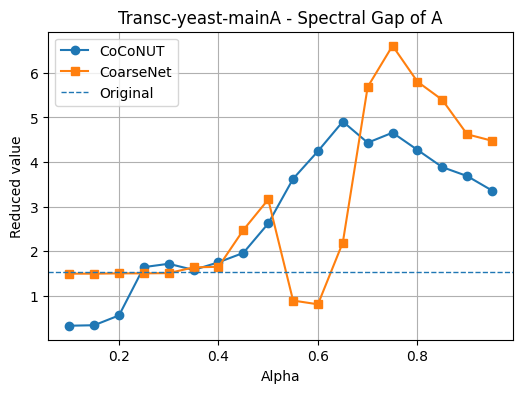

Transc-yeast-mainA - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.198065
  RVI_soft CoarseNet: nan


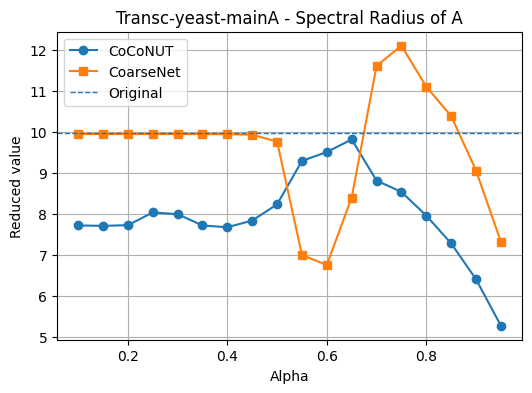

Transc-yeast-mainA - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.477798
  RVI_soft CoarseNet: nan


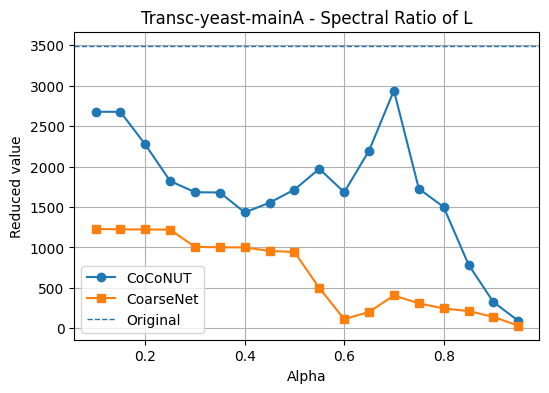

In [39]:
# Metric comparison for 'Transc-yeast-mainA'
plot_graph_metrics("Transc-yeast-mainA", coconut_df, coarsenet_df)

USAir97A - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.111354
  RVI_soft CoarseNet: nan


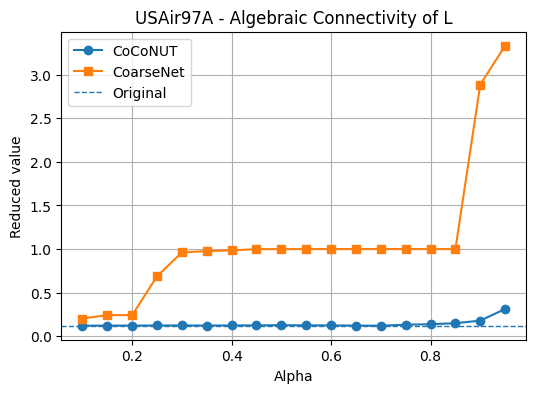

USAir97A - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.633847
  RVI_soft CoarseNet: nan


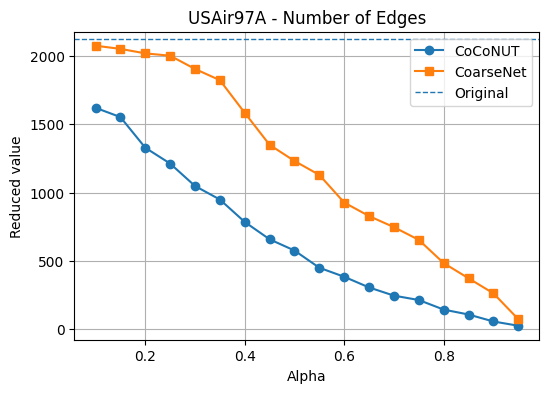

USAir97A - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458533
  RVI_soft CoarseNet: nan


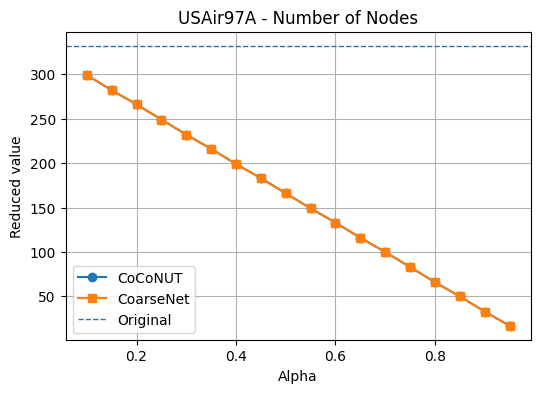

USAir97A - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.531032
  RVI_soft CoarseNet: nan


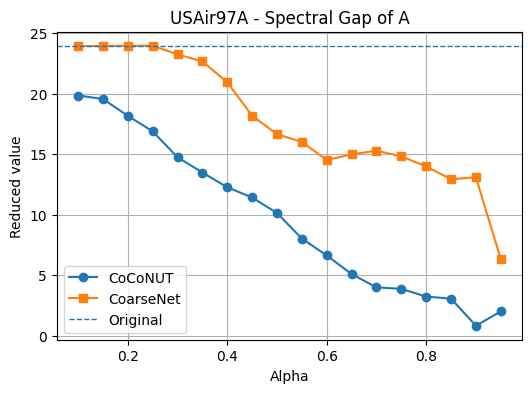

USAir97A - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.490563
  RVI_soft CoarseNet: nan


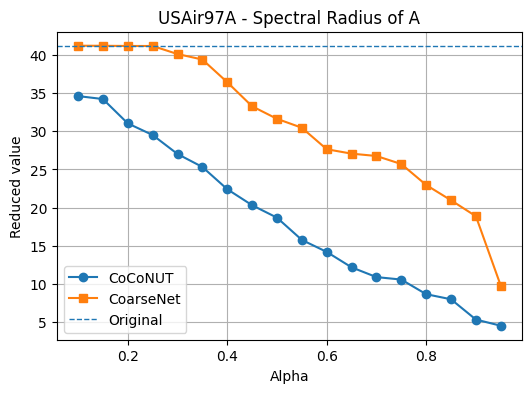

USAir97A - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 0.392440
  RVI_soft CoarseNet: nan


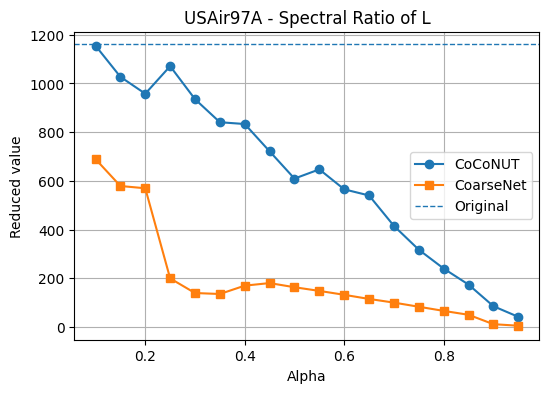

In [40]:
# Metric comparison for 'USAir97A'
plot_graph_metrics("USAir97A", coconut_df, coarsenet_df)

YeastS-main - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.105068
  RVI_soft CoarseNet: nan


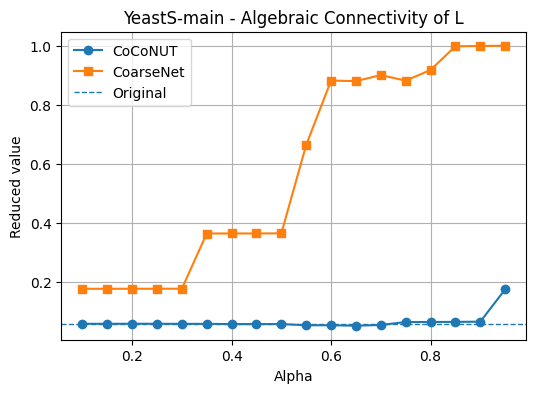

YeastS-main - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.587465
  RVI_soft CoarseNet: nan


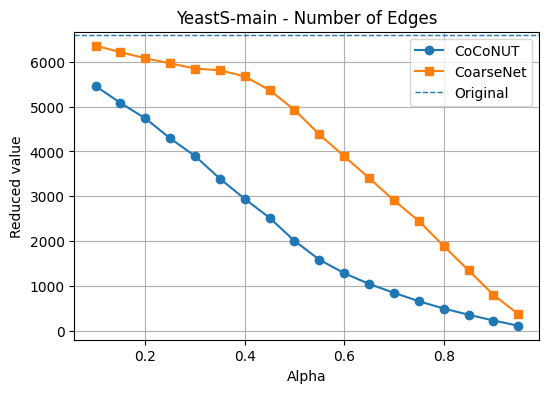

YeastS-main - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458605
  RVI_soft CoarseNet: nan


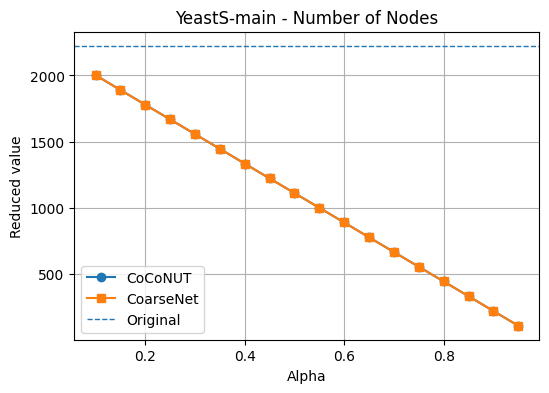

YeastS-main - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 2.978090
  RVI_soft CoarseNet: nan


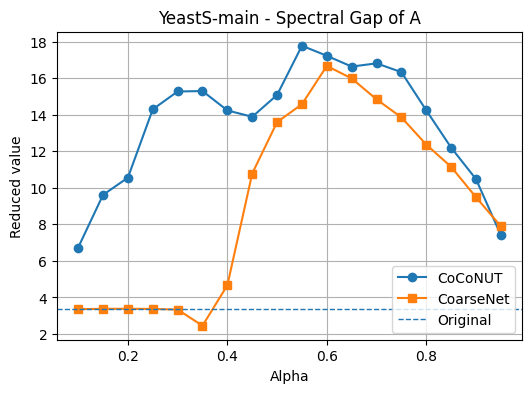

YeastS-main - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.272723
  RVI_soft CoarseNet: nan


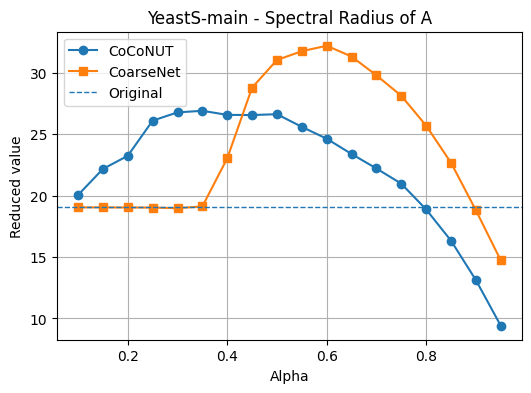

YeastS-main - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 5.945686
  RVI_soft CoarseNet: nan


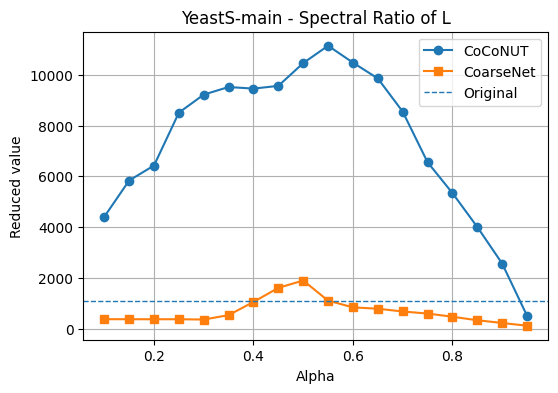

In [41]:
# Metric comparison for 'YeastS-main'
plot_graph_metrics("YeastS-main", coconut_df, coarsenet_df)

geom-main - Algebraic Connectivity of L  tau=1.0
  RVI_soft CoCoNUT  : 0.261904
  RVI_soft CoarseNet: nan


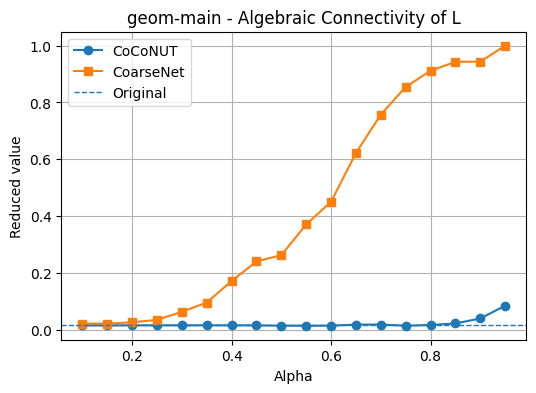

geom-main - Number of Edges  tau=1.0
  RVI_soft CoCoNUT  : 0.574509
  RVI_soft CoarseNet: nan


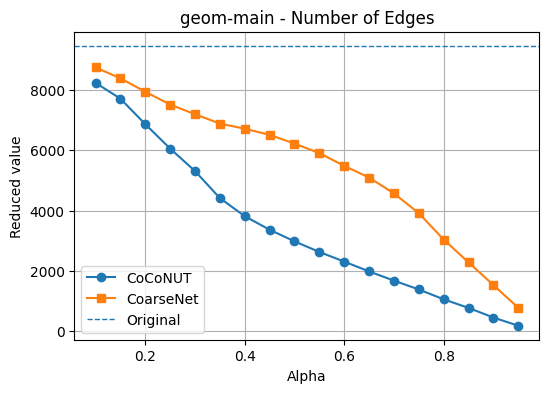

geom-main - Number of Nodes  tau=1.0
  RVI_soft CoCoNUT  : 0.458583
  RVI_soft CoarseNet: nan


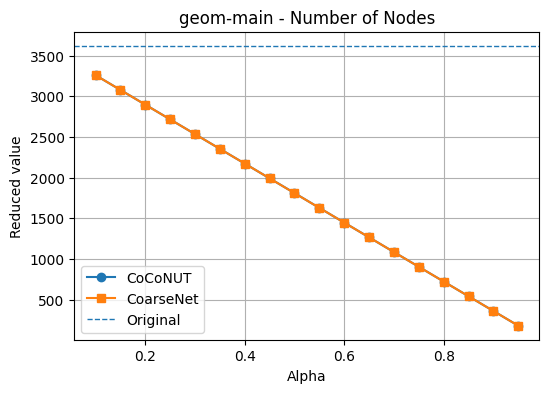

geom-main - Spectral Gap of A  tau=1.0
  RVI_soft CoCoNUT  : 0.389660
  RVI_soft CoarseNet: nan


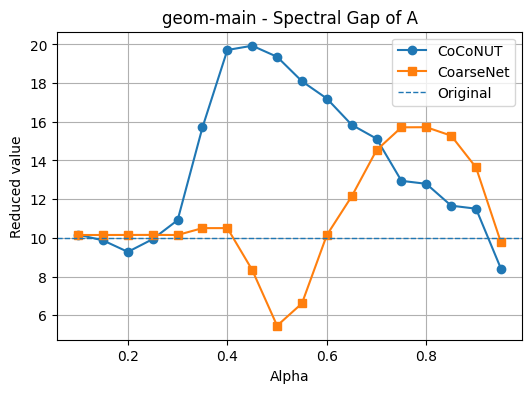

geom-main - Spectral Radius of A  tau=1.0
  RVI_soft CoCoNUT  : 0.141855
  RVI_soft CoarseNet: nan


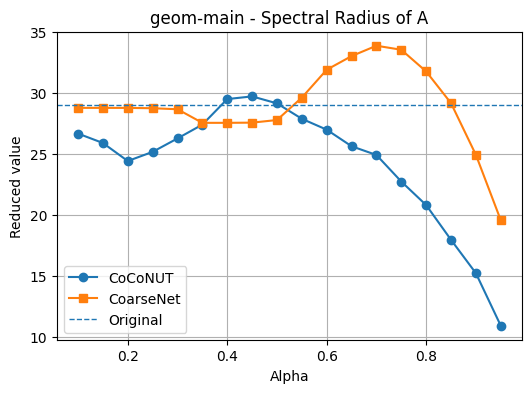

geom-main - Spectral Ratio of L  tau=1.0
  RVI_soft CoCoNUT  : 3.563231
  RVI_soft CoarseNet: nan


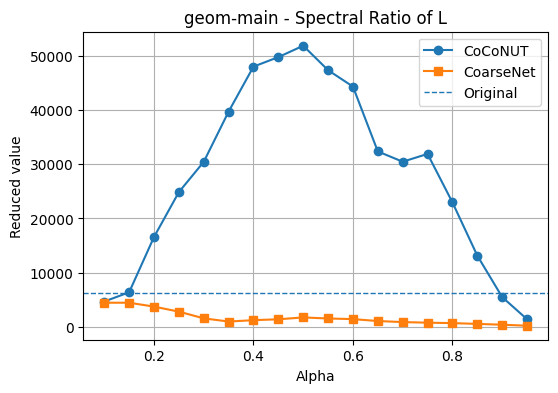

In [42]:
# Metric comparison for 'geom-main'
plot_graph_metrics("geom-main", coconut_df, coarsenet_df)